<a href="https://colab.research.google.com/github/Adarsh-Kmt/Microservice-Boundary-Detection/blob/master/Microservice_Boundary_Detection_Using_Developer_Commit_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydriller scikit-learn pandas matplotlib

In [ ]:
# Colab-ready script: commit -> vectors -> kmeans clustering for microservice boundary detection
# Paste this entire block into a Colab cell and run.
# Requirements: internet access (to GitHub API and optional sentence-transformers download)

# ---------- CONFIG ----------
GITHUB_OWNER = "spring-projects"      # repo owner
GITHUB_REPO  = "spring-petclinic"     # repo name

MAX_COMMITS  = 500                    # fetch more commits for rich clustering
USE_EMBEDDINGS = False                # start with TF-IDF for commit messages/files
                                       # you can switch to True for semantic clustering
EMBEDDING_MODEL = "all-MiniLM-L6-v2"  # used if USE_EMBEDDINGS=True

PICK_K_BY_SILHOUETTE = True           # automatically find best K
K_RANGE = range(2, 12)                # PetClinic is large → wider range helps

RANDOM_STATE = 42
SAVE_RESULTS = True                   # save results to CSV for later analysis

# Optional GitHub token → avoids rate limits
# put a string like "ghp_xxxxxxxx"
GITHUB_TOKEN = None                   # or "your_token_here"
             # set to your token string to increase rate limits (or set as env var)








In [ ]:
# ---------- INSTALLS ----------
# (Only installs what is necessary.)
import sys, subprocess
def pip_install(packages):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade"] + packages)

# installs
needed = []
if USE_EMBEDDINGS:
    needed += ["sentence-transformers"]
needed += ["scikit-learn", "requests", "pandas", "tqdm", "matplotlib", "umap-learn"]
pip_install(needed)

# ---------- IMPORTS ----------
import requests, math, os, time
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import json

if USE_EMBEDDINGS:
    from sentence_transformers import SentenceTransformer

In [ ]:
# ---------- HELPERS: GitHub API ----------
session = requests.Session()
session.headers.update({"Accept": "application/vnd.github.v3+json"})
token = GITHUB_TOKEN or os.environ.get("GITHUB_TOKEN")
if token:
    session.headers.update({"Authorization": f"token {token}"})

def list_commits(owner, repo, per_page=100, max_commits=200):
    commits = []
    url = f"https://api.github.com/repos/{owner}/{repo}/commits"
    page = 1
    while len(commits) < max_commits:
        resp = session.get(url, params={"per_page": per_page, "page": page})
        resp.raise_for_status()
        page_items = resp.json()
        if not page_items:
            break
        commits.extend(page_items)
        if len(page_items) < per_page:
            break
        page += 1
    return commits[:max_commits]

def get_commit_details(commit_url):
    resp = session.get(commit_url)
    resp.raise_for_status()
    return resp.json()


In [ ]:
# ---------- FETCH commits ----------
print(f"Fetching up to {MAX_COMMITS} commits from {GITHUB_OWNER}/{GITHUB_REPO} ...")
raw_commits = list_commits(GITHUB_OWNER, GITHUB_REPO, per_page=100, max_commits=MAX_COMMITS)
print(f"Found {len(raw_commits)} commits (enumerating details)...")

commit_records = []
for item in tqdm(raw_commits, desc="commits"):
    sha = item.get("sha")
    commit_url = item.get("url")  # API URL for the commit
    try:
        detail = get_commit_details(commit_url)
    except Exception as e:
        print(f"Skipping commit {sha}: {e}")
        continue
    commit_msg = detail.get("commit", {}).get("message", "") or ""
    author = detail.get("commit", {}).get("author", {}).get("name", "") or ""
    date = detail.get("commit", {}).get("author", {}).get("date", "")
    files = detail.get("files", []) or []
    filenames = [f.get("filename", "") for f in files]
    # build a compact textual representation:
    # include message, filenames, and a short summary of diff (patch truncated)
    patches = []
    for f in files:
        p = f.get("patch")
        if p:
            # keep only first N chars of patch per file to avoid huge text
            patches.append((f.get("filename",""), p[:1000]))
    patch_text = " ".join([f"{fn}::{p}" for fn,p in patches])
    text = " ".join([commit_msg, "FILES:", ";".join(filenames), "PATCH:", patch_text])
    commit_records.append({
        "sha": sha,
        "author": author,
        "date": date,
        "message": commit_msg,
        "filenames": filenames,
        "patch_text": patch_text,
        "text": text,
        "raw": detail
    })

if len(commit_records) == 0:
    raise SystemExit("No commits fetched — check repo name / token / network.")

Fetching up to 500 commits from spring-projects/spring-petclinic ...
Found 500 commits (enumerating details)...


commits:  11%|█         | 55/500 [00:11<00:28, 15.66it/s]

Skipping commit 300597fc6cc765a8f167c2daff33cf165abd17b9: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/300597fc6cc765a8f167c2daff33cf165abd17b9
Skipping commit 40a41375e6b55d5cf246c483d63fa9380ccb9ff1: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/40a41375e6b55d5cf246c483d63fa9380ccb9ff1
Skipping commit 214a8fb87f5fb7124010b31f04f9591b9a0aa9e4: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/214a8fb87f5fb7124010b31f04f9591b9a0aa9e4
Skipping commit a0ba075bd86d3940e6bbcb74612103a611aa2da4: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/a0ba075bd86d3940e6bbcb74612103a611aa2da4
Skipping commit 91f55a4f7134409a832435de2c6df231102d5898: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/sp

commits:  15%|█▍        | 74/500 [00:11<00:11, 36.87it/s]

Skipping commit dff45cf70cd578d0dea6fd38f9f28327b74b5c1b: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/dff45cf70cd578d0dea6fd38f9f28327b74b5c1b
Skipping commit 90bbb98ea6068f13517207a3165f89f6dcbc0530: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/90bbb98ea6068f13517207a3165f89f6dcbc0530
Skipping commit bbb237928fa9ef24a09ce57ad01075e4b7eb78c8: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/bbb237928fa9ef24a09ce57ad01075e4b7eb78c8
Skipping commit 912de1648e32012706eb8623af1e42f334d7964a: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/912de1648e32012706eb8623af1e42f334d7964a
Skipping commit 62dbfa8e9ae6486833a9b03ff63ba330349ae48f: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/sp

commits:  17%|█▋        | 86/500 [00:12<00:08, 46.24it/s]

Skipping commit cabb74ed53624ea815130ff8eccf68ab01bc2da3: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/cabb74ed53624ea815130ff8eccf68ab01bc2da3
Skipping commit 91328af12d782b9f602cd7d52c76b9a3eebde949: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/91328af12d782b9f602cd7d52c76b9a3eebde949
Skipping commit 12eb8b1ff3b463fa3cf430fd202449f41397291d: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/12eb8b1ff3b463fa3cf430fd202449f41397291d
Skipping commit 383edc1656e305f8151c258b6925df00f7b53655: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/383edc1656e305f8151c258b6925df00f7b53655
Skipping commit d8fcd11e677102a795326ef73df09b50a646f849: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/sp

commits:  20%|█▉        | 98/500 [00:12<00:08, 49.16it/s]

Skipping commit 6fa3fa8196b2837b8cd67c5231db925481323cfc: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/6fa3fa8196b2837b8cd67c5231db925481323cfc
Skipping commit 527dad0c17f1f8ff10a658fda193fc304b2be9ec: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/527dad0c17f1f8ff10a658fda193fc304b2be9ec
Skipping commit 284d07942e51f00d29ce37a333d35dbbf6ee7331: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/284d07942e51f00d29ce37a333d35dbbf6ee7331
Skipping commit 405cdc635b10770a2f5ed70be973cdf905cfa736: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/405cdc635b10770a2f5ed70be973cdf905cfa736
Skipping commit c7bc8b1ae618bf63ba097c1ff8e0ea5235baadb4: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/sp

commits:  22%|██▏       | 110/500 [00:12<00:07, 52.41it/s]

Skipping commit 7055f0c6a6c99d89ba89be112969bb34f72212bb: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/7055f0c6a6c99d89ba89be112969bb34f72212bb
Skipping commit c5b3b3597ee4954a15c57767b4de432d160136e6: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/c5b3b3597ee4954a15c57767b4de432d160136e6
Skipping commit ca5785465f857d75d50b014d6d5abcd922255fac: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/ca5785465f857d75d50b014d6d5abcd922255fac
Skipping commit d604a0198467f1463753e488ca103867e7ff280e: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/d604a0198467f1463753e488ca103867e7ff280e
Skipping commit 57eb7443a638493d1c81672a29fb712eb1b99b4a: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  25%|██▍       | 123/500 [00:12<00:06, 57.26it/s]

Skipping commit 4148fc9eb31d6186adb3a65ecfee97669e57baa9: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/4148fc9eb31d6186adb3a65ecfee97669e57baa9
Skipping commit a2f1ad5503a7987a94cdc18a9bc2af2ef8d52af7: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/a2f1ad5503a7987a94cdc18a9bc2af2ef8d52af7
Skipping commit da1c93d367223dd3e648d3861f95fb9c40314f8a: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/da1c93d367223dd3e648d3861f95fb9c40314f8a
Skipping commit ee6573cee08f7aae79fac21e15a55e5ff43b5483: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/ee6573cee08f7aae79fac21e15a55e5ff43b5483
Skipping commit 836d111e9950f6abedb4fef7b4a94941b8dfedd8: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  27%|██▋       | 137/500 [00:13<00:05, 61.97it/s]

Skipping commit d69204f2c1457f0ff2086eb5e9e08f0b5b3889aa: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/d69204f2c1457f0ff2086eb5e9e08f0b5b3889aa
Skipping commit 8b8304fa256d0d06092d343d857e0768450ca9e1: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/8b8304fa256d0d06092d343d857e0768450ca9e1
Skipping commit de0e3663c033ac9b51f2fb497bc32edf7558277b: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/de0e3663c033ac9b51f2fb497bc32edf7558277b
Skipping commit 5a9d1fc40f3251cf9ed720cfb46517b7fb92ad84: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/5a9d1fc40f3251cf9ed720cfb46517b7fb92ad84
Skipping commit 923e2b7aa331b8194a6579da99fb6388f15d7f3e: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  30%|███       | 151/500 [00:13<00:05, 61.20it/s]

Skipping commit 029de905b3e9493df193d6f949d733be59a78f51: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/029de905b3e9493df193d6f949d733be59a78f51
Skipping commit ca2d8dbc0950f1c0faca8cad8988a554e3154866: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/ca2d8dbc0950f1c0faca8cad8988a554e3154866
Skipping commit 10e3dc9376dc8d49a289ef030b7c04127d37d3b3: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/10e3dc9376dc8d49a289ef030b7c04127d37d3b3
Skipping commit 768e1ed5e9c75cb74797496a2439f9e14fcb1faa: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/768e1ed5e9c75cb74797496a2439f9e14fcb1faa
Skipping commit 3c1ef72e6d45ef41fbc86f51476e5a72e9e66564: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  32%|███▏      | 159/500 [00:13<00:05, 63.41it/s]

Skipping commit 8a5a14e88a07665c97638dd81a31fb4e6c336194: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/8a5a14e88a07665c97638dd81a31fb4e6c336194
Skipping commit 6e71aaa44cbd147a000d3a7b4bd5db55244948bf: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/6e71aaa44cbd147a000d3a7b4bd5db55244948bf
Skipping commit b94d30626f5399e01a68b39f08d1e2075cd8c429: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/b94d30626f5399e01a68b39f08d1e2075cd8c429
Skipping commit 7b1abb3ca9a0a47afbcf4299638fc09e37b2405a: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/7b1abb3ca9a0a47afbcf4299638fc09e37b2405a
Skipping commit 0962ed7e8f5df8cf287c79975f9894f3189aebab: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  35%|███▍      | 174/500 [00:13<00:05, 62.35it/s]

Skipping commit ca055dbbe1f05a91c355242552a0b7ed20569a60: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/ca055dbbe1f05a91c355242552a0b7ed20569a60
Skipping commit 10b13eb5b1f7f287774df05074bbff963a4d2907: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/10b13eb5b1f7f287774df05074bbff963a4d2907
Skipping commit 6be2a5870d328dc10bffbcf17b424e67cb4720ef: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/6be2a5870d328dc10bffbcf17b424e67cb4720ef
Skipping commit 05468bc14b34e1486414994bbe003a81308be147: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/05468bc14b34e1486414994bbe003a81308be147
Skipping commit 6580e8b6cfa246422399eb0640ef93c30396115d: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  38%|███▊      | 189/500 [00:13<00:04, 67.21it/s]

Skipping commit a5cbb8505a1df3c348c06607933a07fc8c87c222: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/a5cbb8505a1df3c348c06607933a07fc8c87c222
Skipping commit 89f7b4ee96b8dd354d56ff2211bb1ffe762ba24c: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/89f7b4ee96b8dd354d56ff2211bb1ffe762ba24c
Skipping commit f48227aea0e4056e1b9105494ea2f6360f3975f3: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/f48227aea0e4056e1b9105494ea2f6360f3975f3
Skipping commit 7e91b98f713557ffd980535cf02d8a8e397a20f0: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/7e91b98f713557ffd980535cf02d8a8e397a20f0
Skipping commit 70f615afd15f4651be1a55dddb5e3df0cf6e8234: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  41%|████      | 204/500 [00:14<00:04, 65.64it/s]

Skipping commit 5aef5c380c564d9c22afef3e173b1ec6af2c54bd: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/5aef5c380c564d9c22afef3e173b1ec6af2c54bd
Skipping commit cbf80df5cc81701b32c069f9afd42280e0936ed2: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/cbf80df5cc81701b32c069f9afd42280e0936ed2
Skipping commit 5ef819085b28010f6403d331698f6930d47ec169: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/5ef819085b28010f6403d331698f6930d47ec169
Skipping commit 80d03f3cefadd64488fb60ce5bcd9f6ab3d44000: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/80d03f3cefadd64488fb60ce5bcd9f6ab3d44000
Skipping commit 2a12048e784eae86e61a484ecb65eec8832b9b9a: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  44%|████▎     | 218/500 [00:14<00:04, 59.10it/s]

Skipping commit 0827bc8181a0b81a03e640604ee23329f83dc5f2: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0827bc8181a0b81a03e640604ee23329f83dc5f2
Skipping commit 31e5aa623eea28c2a73eef9bccbbf8e031fe04f1: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/31e5aa623eea28c2a73eef9bccbbf8e031fe04f1
Skipping commit 60ddc68387816baeb0315c33670e622deff4079a: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/60ddc68387816baeb0315c33670e622deff4079a
Skipping commit 702747f4330073c6f73fbec426e0e0dcdaa2c33d: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/702747f4330073c6f73fbec426e0e0dcdaa2c33d
Skipping commit 604c9c51a39fb5154965a9077a16d9cf28309463: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  46%|████▌     | 231/500 [00:14<00:04, 58.76it/s]

Skipping commit 8a28801d1a484d93ad3ddc00888fac7835f00eca: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/8a28801d1a484d93ad3ddc00888fac7835f00eca
Skipping commit 472575378c7b377862cc01b713cab38eaa8f9c64: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/472575378c7b377862cc01b713cab38eaa8f9c64
Skipping commit b559077f14b6f1e197228ff6cb7395514f09326f: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/b559077f14b6f1e197228ff6cb7395514f09326f
Skipping commit 43beff91a355f0b86f4c239ada0570faddf7e737: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/43beff91a355f0b86f4c239ada0570faddf7e737
Skipping commit 423a3375434eb90d1631a47849fd5e56700585f7: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  49%|████▉     | 247/500 [00:14<00:03, 66.86it/s]

Skipping commit ce626da705302e71771b7e22429d1cc3209e7ebb: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/ce626da705302e71771b7e22429d1cc3209e7ebb
Skipping commit 20adfb71be4d7a50779e83abef98cdd3c01a1908: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/20adfb71be4d7a50779e83abef98cdd3c01a1908
Skipping commit eff7c9529f0ec709e4443c334732afdb82acb301: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/eff7c9529f0ec709e4443c334732afdb82acb301
Skipping commit 67c8bf6a1f3dc44cc4a529b89c7f3ea1757e2c9c: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/67c8bf6a1f3dc44cc4a529b89c7f3ea1757e2c9c
Skipping commit 83e074940b23ae4fd35e67e20b94a8e4c46687c3: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  52%|█████▏    | 261/500 [00:14<00:03, 65.50it/s]

Skipping commit 198f5e288c16d5137ab4b7f7fb5c642d300592b1: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/198f5e288c16d5137ab4b7f7fb5c642d300592b1
Skipping commit 0016ae911248ab850d7d2492947ae50aeb9af7aa: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0016ae911248ab850d7d2492947ae50aeb9af7aa
Skipping commit 01621077cbf76aa873eab64f0f0f50aaf6a04b90: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/01621077cbf76aa873eab64f0f0f50aaf6a04b90
Skipping commit af9a0a423e8e7237631ac8e3292594b669ff3246: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/af9a0a423e8e7237631ac8e3292594b669ff3246
Skipping commit 8bfe9e68bf22342c51aa9f4f3acea878b8036953: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  55%|█████▌    | 275/500 [00:15<00:03, 64.09it/s]

Skipping commit b91e21378c218189892e964732918e1c93d9a8e2: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/b91e21378c218189892e964732918e1c93d9a8e2
Skipping commit 8954fa9585b02ba035662ab1385dce20a8c15efc: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/8954fa9585b02ba035662ab1385dce20a8c15efc
Skipping commit 0d8a80da65315dc898ec07a0c38948288cf2e2b3: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0d8a80da65315dc898ec07a0c38948288cf2e2b3
Skipping commit 525dc6a2d058cd1126cbcf223239164e53498a49: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/525dc6a2d058cd1126cbcf223239164e53498a49
Skipping commit d0e4e7731bdfcd3bea8735fd6944f22e327d376b: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  58%|█████▊    | 291/500 [00:15<00:03, 69.57it/s]

Skipping commit 0573cda3c2b07d37424b27a63f4514d63fbb3cfb: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0573cda3c2b07d37424b27a63f4514d63fbb3cfb
Skipping commit 502870d6c031692b2111602a3eae5ae00e24efd9: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/502870d6c031692b2111602a3eae5ae00e24efd9
Skipping commit 949278cd46971a2170d749be0cfe2a1223161001: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/949278cd46971a2170d749be0cfe2a1223161001
Skipping commit ab9135ad9bbc8631221caf0a7ee3eadd0561311d: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/ab9135ad9bbc8631221caf0a7ee3eadd0561311d
Skipping commit 8b1ac6736e3347f34d79620170983fc4c99746cb: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  60%|█████▉    | 299/500 [00:15<00:02, 70.20it/s]

Skipping commit 5ad6bc3ccde1c61379d751f0751a1731114761af: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/5ad6bc3ccde1c61379d751f0751a1731114761af
Skipping commit 4953f87917b449a404a7f1f4e2457836b9eafbbc: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/4953f87917b449a404a7f1f4e2457836b9eafbbc
Skipping commit 0390e85c252a58917954ec682775c6672159b58c: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0390e85c252a58917954ec682775c6672159b58c
Skipping commit d367e2b4b41a2de899b0f438bc984a7c1c011b77: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/d367e2b4b41a2de899b0f438bc984a7c1c011b77
Skipping commit 73ede82651bf1e733b26e6c630f2aac9c855e900: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  63%|██████▎   | 315/500 [00:15<00:02, 68.21it/s]

Skipping commit 628862206bd20efcce9ae5f97b89aad59bb2c9ca: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/628862206bd20efcce9ae5f97b89aad59bb2c9ca
Skipping commit d9f37ece5c865ded91b6582828142ccc33e9d54f: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/d9f37ece5c865ded91b6582828142ccc33e9d54f
Skipping commit 56f09331aa627fe8e07d5f3b20e1ec50f2828fb4: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/56f09331aa627fe8e07d5f3b20e1ec50f2828fb4
Skipping commit 8db8c272c102127664d8896ebe63d9d2af76359e: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/8db8c272c102127664d8896ebe63d9d2af76359e
Skipping commit 8805eaa721a6ce59cbd7870653dc28afda806c0a: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  66%|██████▌   | 331/500 [00:15<00:02, 68.65it/s]

Skipping commit 93873665453584deb891569c02e3acc7283cf394: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/93873665453584deb891569c02e3acc7283cf394
Skipping commit 108a81b946fc12c22dcaf10d7b500daf6969a1be: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/108a81b946fc12c22dcaf10d7b500daf6969a1be
Skipping commit 4e1f87407d80cdb4a5a293de89d62034fdcbb847: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/4e1f87407d80cdb4a5a293de89d62034fdcbb847
Skipping commit 82cb521d636b282340378d80a6307a08e3d4a4c4: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/82cb521d636b282340378d80a6307a08e3d4a4c4
Skipping commit 5d57e0d5e25fa5ff633719f36f8c4ce67ec1893c: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  69%|██████▉   | 345/500 [00:16<00:02, 63.79it/s]

Skipping commit f284b29501946f933ee4473ecf59096d013df31c: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/f284b29501946f933ee4473ecf59096d013df31c
Skipping commit bb7e84776dfa73bb66b9c3e9530b11bcaacb0dba: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/bb7e84776dfa73bb66b9c3e9530b11bcaacb0dba
Skipping commit ecae6d71c39544ff575b0298fbb3c631c96a1fe4: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/ecae6d71c39544ff575b0298fbb3c631c96a1fe4
Skipping commit e280d12144b388ea58f90961f9b22500b29c8e3e: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/e280d12144b388ea58f90961f9b22500b29c8e3e
Skipping commit 7ef045dac8effb41d5f24c1e1011869b59a3d0a2: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  72%|███████▏  | 359/500 [00:16<00:02, 58.44it/s]

Skipping commit 8394b7dd219b40d0e606ef12356a9644c866a265: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/8394b7dd219b40d0e606ef12356a9644c866a265
Skipping commit dc337f580c763c29ea3857cb9c79e9e23fce80d5: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/dc337f580c763c29ea3857cb9c79e9e23fce80d5
Skipping commit 39897cc149588ca413c4cc9f4cb4b6d599ee73c5: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/39897cc149588ca413c4cc9f4cb4b6d599ee73c5
Skipping commit bebe9e50ed5d85c11768d2250461ae87ef8ecd44: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/bebe9e50ed5d85c11768d2250461ae87ef8ecd44
Skipping commit 8919c7317b26854dd742be5ebd345badaed0bcb2: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  75%|███████▍  | 374/500 [00:16<00:01, 63.69it/s]

Skipping commit f4bed3cc17948bde8408e371bc58d5694534cefb: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/f4bed3cc17948bde8408e371bc58d5694534cefb
Skipping commit 0c59090c1a805923f01bebde87004a3d3e8948e8: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0c59090c1a805923f01bebde87004a3d3e8948e8
Skipping commit be60080f4be4555bfbfe50186f86b23a33de8a82: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/be60080f4be4555bfbfe50186f86b23a33de8a82
Skipping commit eef57abd78533120f65b9d83c7d3b54a1b2bc5d7: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/eef57abd78533120f65b9d83c7d3b54a1b2bc5d7
Skipping commit 91fa97102ff17280f6b00d65ebc8e4a6499b484a: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  78%|███████▊  | 389/500 [00:16<00:01, 67.22it/s]

Skipping commit 1ada9baeaa1d11676f93ecaef0dc76155777f2bc: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/1ada9baeaa1d11676f93ecaef0dc76155777f2bc
Skipping commit 8bee2f888db7c7347cd419fe61064398f7a93ee6: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/8bee2f888db7c7347cd419fe61064398f7a93ee6
Skipping commit 6de956210e7b72d527d49e0d375d7b2311dbde59: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/6de956210e7b72d527d49e0d375d7b2311dbde59
Skipping commit 71cfa2be6c988b14ee9b3c4f17cd71d41624c17c: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/71cfa2be6c988b14ee9b3c4f17cd71d41624c17c
Skipping commit e0684bfd5e3adb1815e32675f384085644dad076: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  79%|███████▉  | 396/500 [00:17<00:01, 64.65it/s]

Skipping commit 22ff39853d7c53a4e13319729275f0e8cdae2c99: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/22ff39853d7c53a4e13319729275f0e8cdae2c99
Skipping commit 645ebc4fb89318ab2b72f46c19439b710340d1d6: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/645ebc4fb89318ab2b72f46c19439b710340d1d6
Skipping commit 02ef5939f93fdd6e7d418fde915e906c5b41c70c: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/02ef5939f93fdd6e7d418fde915e906c5b41c70c
Skipping commit 1a317e62d1e2976c3e0990d978f5165e104500f7: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/1a317e62d1e2976c3e0990d978f5165e104500f7
Skipping commit 895422b8c8ddb1d0f94a51da2c66a3c86b09e930: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  82%|████████▏ | 411/500 [00:17<00:01, 65.75it/s]

Skipping commit 38bd3280cbb765c5e3045f646f9c09523d0ba051: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/38bd3280cbb765c5e3045f646f9c09523d0ba051
Skipping commit 5270246eb587ca4837889aefb37f26b8019aca4f: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/5270246eb587ca4837889aefb37f26b8019aca4f
Skipping commit 4d6ee8410dd4b1d4a672982bec968519fa196eb8: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/4d6ee8410dd4b1d4a672982bec968519fa196eb8
Skipping commit 44060315cc53e3351276e2354a98adde917451ba: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/44060315cc53e3351276e2354a98adde917451ba
Skipping commit eebca43df803aeb08754f43a86d6996630063500: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  85%|████████▌ | 425/500 [00:17<00:01, 65.18it/s]

Skipping commit 0d847edfdb6447c45e98205a102980f7e3a9c4ea: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0d847edfdb6447c45e98205a102980f7e3a9c4ea
Skipping commit 106226929b527c27359b0215bc2569121cd80401: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/106226929b527c27359b0215bc2569121cd80401
Skipping commit dfcd30be601439c933785456a5551578467b9573: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/dfcd30be601439c933785456a5551578467b9573
Skipping commit 34545e72a4b9a21aff7e2c609001bb74d6e01d98: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/34545e72a4b9a21aff7e2c609001bb74d6e01d98
Skipping commit c5abf45cbc78ca997a1a5934673b93077ca4e907: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  88%|████████▊ | 439/500 [00:17<00:01, 59.29it/s]

Skipping commit 23f65ba7d0101adeb32f36fd8f634549ee3d6e40: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/23f65ba7d0101adeb32f36fd8f634549ee3d6e40
Skipping commit 45da5a4d3b7ac2aae6bd6a43cafa0e2e2c646cc5: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/45da5a4d3b7ac2aae6bd6a43cafa0e2e2c646cc5
Skipping commit 5b0f037d06de2c9ad3be4fdf52402ddb5667e2da: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/5b0f037d06de2c9ad3be4fdf52402ddb5667e2da
Skipping commit 3e65dee2371d4517fa29d6de44d2a77f0ff3065c: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/3e65dee2371d4517fa29d6de44d2a77f0ff3065c
Skipping commit 4ab6a800c84657b8c8fad5611f7ba2ebf87ee219: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  91%|█████████ | 453/500 [00:17<00:00, 62.01it/s]

Skipping commit ffa967c94b65a70ea6d3b44275632821838d9fd3: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/ffa967c94b65a70ea6d3b44275632821838d9fd3
Skipping commit fd1c742d4f8d193eb935519909c15302b783cd52: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/fd1c742d4f8d193eb935519909c15302b783cd52
Skipping commit f792522b3dffca918f52010c8593999088034e19: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/f792522b3dffca918f52010c8593999088034e19
Skipping commit 75912a06c5613a2ea1305ad4d8ad6bc4be7765ce: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/75912a06c5613a2ea1305ad4d8ad6bc4be7765ce
Skipping commit 443d35eae23c874ed38305fbe75216339c41beaf: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  93%|█████████▎| 467/500 [00:18<00:00, 58.99it/s]

Skipping commit 0f840cd50bdff41206dd6f3ae8aebdbb09bac8b3: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0f840cd50bdff41206dd6f3ae8aebdbb09bac8b3
Skipping commit 6da37c30d3ba6fe915b6e61324a188b81cb2fb42: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/6da37c30d3ba6fe915b6e61324a188b81cb2fb42
Skipping commit 0c7db646ef89c7435f739f5f7dd4db60505ab8aa: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0c7db646ef89c7435f739f5f7dd4db60505ab8aa
Skipping commit 8b76a54814e5e3bee8d14656c04b3a6b33c39c89: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/8b76a54814e5e3bee8d14656c04b3a6b33c39c89
Skipping commit 837483f1d0ade91dffc21784842534da803b2f44: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  96%|█████████▋| 482/500 [00:18<00:00, 62.11it/s]

Skipping commit 131a588e09c67a53ab91c4928b2896dc035f8cee: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/131a588e09c67a53ab91c4928b2896dc035f8cee
Skipping commit e20b96a4c2f892ad56479e4ed1186c89390debfe: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/e20b96a4c2f892ad56479e4ed1186c89390debfe
Skipping commit 83ff9a50e378529993f4f772457dd24791b46438: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/83ff9a50e378529993f4f772457dd24791b46438
Skipping commit 8c8599298a4dc221ced4d66f8d265d89cf357102: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/8c8599298a4dc221ced4d66f8d265d89cf357102
Skipping commit adc92a49cc2f1e784596e1cfd968862a2b8c8643: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits:  99%|█████████▉| 496/500 [00:18<00:00, 64.77it/s]

Skipping commit 6ff35b6c22430ac71c063214fd3270e3c13927c3: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/6ff35b6c22430ac71c063214fd3270e3c13927c3
Skipping commit b889abbe7f503af94c8576a124482867c75e6185: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/b889abbe7f503af94c8576a124482867c75e6185
Skipping commit c0ac1ffda626917f5553d427910e1dc33d337c05: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/c0ac1ffda626917f5553d427910e1dc33d337c05
Skipping commit a9b6565fcf24d59ec29f32c4d8e5c9001d7e1988: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/a9b6565fcf24d59ec29f32c4d8e5c9001d7e1988
Skipping commit 4d90e7e394606e5eebbb630082cd1f308c1674ca: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-proje

commits: 100%|██████████| 500/500 [00:18<00:00, 26.75it/s]

Skipping commit 0adaea9efa126f25b59cd9ef97ae79a106f24c54: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/0adaea9efa126f25b59cd9ef97ae79a106f24c54
Skipping commit 84d5e8270de4e0a02f1d1c45af9a383d3c42b321: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/84d5e8270de4e0a02f1d1c45af9a383d3c42b321
Skipping commit ef4a8088284bc7d6fab1f85706844a5c5d38a77f: 429 Client Error: too many requests for url: https://api.github.com/repos/spring-projects/spring-petclinic/commits/ef4a8088284bc7d6fab1f85706844a5c5d38a77f


In [ ]:
# ---------- VECTORIZE ----------
texts = [r["text"] for r in commit_records]
if USE_EMBEDDINGS:
    print("Loading sentence-transformers model (semantic embeddings) ...")
    model = SentenceTransformer(EMBEDDING_MODEL)
    X = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
else:
    print("Vectorizing with TF-IDF ...")
    # tune min_df and ngram_range to suit commit text size
    vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=1)
    X = vectorizer.fit_transform(texts)
    # convert to dense for some algorithms (KMeans supports sparse but we'll keep dense for silhouette convenience)
    X = X.toarray()

print("Vector shape:", X.shape)

Vectorizing with TF-IDF ...
Vector shape: (47, 3000)


In [ ]:
# ---------- PICK K and CLUSTER ----------
def pick_best_k_and_cluster(X, k_range=range(2,8), random_state=RANDOM_STATE):
    best_k = None
    best_score = -1
    best_labels = None
    best_model = None
    for k in k_range:
        if k >= X.shape[0]:
            break
        model = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
        labels = model.fit_predict(X)
        # silhouette requires at least 2 clusters with >1 sample each
        try:
            score = silhouette_score(X, labels)
        except Exception:
            score = -1
        print(f"k={k}, silhouette={score:.4f}")
        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels
            best_model = model
    return best_k, best_model, best_labels, best_score

if PICK_K_BY_SILHOUETTE:
    search_range = [k for k in K_RANGE if k < len(commit_records)]
    if len(search_range) < 1:
        search_range = [2] if len(commit_records) > 1 else [1]
    best_k, best_model, labels, best_score = pick_best_k_and_cluster(X, k_range=search_range)
    print(f"Best k={best_k} (silhouette={best_score:.4f})")
else:
    best_k = 3
    best_model = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
    labels = best_model.fit_predict(X)

# attach cluster labels
for rec, lab in zip(commit_records, labels):
    rec["cluster"] = int(lab)


k=2, silhouette=0.0681
k=3, silhouette=0.0774
k=4, silhouette=0.0524
k=5, silhouette=0.0640
k=6, silhouette=0.0634
k=7, silhouette=0.0764
k=8, silhouette=0.1040
k=9, silhouette=0.1084
k=10, silhouette=0.1163
k=11, silhouette=0.1158
Best k=10 (silhouette=0.1163)


In [ ]:
# ---------- ANALYSIS: top terms per cluster & representative commits ----------
results = pd.DataFrame(commit_records)
if not USE_EMBEDDINGS:
    # compute mean TF-IDF per cluster and show top terms
    centroids = best_model.cluster_centers_
    feature_names = vectorizer.get_feature_names_out()
    top_terms = {}
    for i in range(best_k):
        top_idx = np.argsort(centroids[i])[::-1][:15]
        top_terms[i] = [feature_names[j] for j in top_idx]
    print("\nTop terms per cluster (TF-IDF):")
    for i in range(best_k):
        print(f"Cluster {i}: ", ", ".join(top_terms[i][:10]))
else:
    print("\nUsing semantic embeddings — top terms unavailable (use filenames/messages to interpret).")

# show representative commits per cluster (closest to centroid)
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(best_model.cluster_centers_, X)
print("\nRepresentative commits (closest to each cluster center):")
for i, idx in enumerate(closest):
    rec = commit_records[idx]
    print(f"[Cluster {i}] sha={rec['sha']} author={rec['author']} msg={rec['message'][:120]} ...")
    print("   files:", rec["filenames"][:6])
    print()


Top terms per cluster (TF-IDF):
Cluster 0:  spring, spr, browse, boot, https, for aot, workaround for, workaround, reactor, hv
Cluster 1:  pet, java, owner, springframework, org springframework, org, import, samples petclinic, public, springframework samples
Cluster 2:  th, text, label, th text, div, class, html, span, form, resources
Cluster 3:  gradle, wrapper, gradle wrapper, wrapper gradle, classpath, gradle org, distributionurl https, zip, wrapper properties, distributionurl
Cluster 4:  import, org springframework, springframework, org, import org, java, samples petclinic, owner, springframework samples, samples
Cluster 5:  mysql, docker, mysqlcontainer, postgres, petclinic, compose, docker compose, container, 3306, java
Cluster 6:  messages, error, resources messages, resources, main resources, properties, 46, src main, typemismatch, main
Cluster 7:  the, spring, readme, version, https, petclinic, https spring, gs, io guides, guides gs
Cluster 8:  version, postgres, build, id, v

Computing 2D projection (t-SNE) for visualization ...


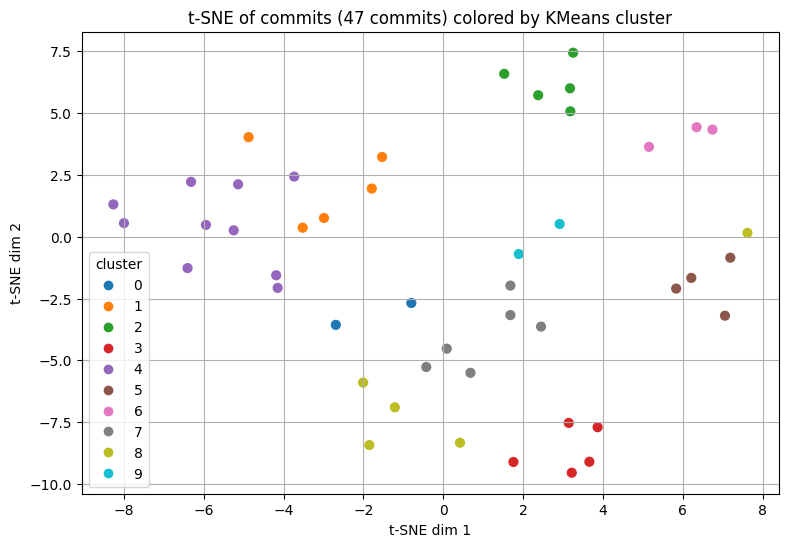

In [ ]:
print("Computing 2D projection (t-SNE) for visualization ...")
perplexity = max(2, min(30, len(commit_records) // 3))

tsne = TSNE(
    n_components=2,
    random_state=RANDOM_STATE,
    init="pca",
    learning_rate="auto",
    perplexity=perplexity
)

X2 = tsne.fit_transform(X)

plt.figure(figsize=(9,6))
scatter = plt.scatter(X2[:,0], X2[:,1], c=labels, cmap='tab10', s=40)
plt.title(f"t-SNE of commits ({len(commit_records)} commits) colored by KMeans cluster")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(*scatter.legend_elements(), title="cluster")
plt.grid(True)
plt.show()
